In [ ]:
================= 直接 AE 生成的效果
1. USE FIX ENCODE LAYER of "1" classify
比较模糊

2. USE UNFIXED ENCODE LAYER
相对清晰了一些

3. 其他
USE STRAIGHT POOLING + DECODE_LAYER，直接做一个直觉的 encode 是不是也差不多呢？

2. 

In [ ]:
# Some points
1. a = sess.run(xx) 可以把值作为 ndarray 用a变量带出来

============================= 最小子集问题
============================== 几个没解决的 api问题：

0. 怎么对部分层 set_weights + freeze layer ?
怎么自定义 layer 支持更复杂的 tf 计算？

1. 当不同的keras model 共享了同一层 layer 的时候（比如整体的模型 tensor 同时定义出几个model的定义方式），
model.fit的时候有没有可能导致更新了同一层参数？以下是 model 内嵌 model
https://stackoverflow.com/questions/50283844/in-keras-how-to-get-the-layer-name-associated-with-a-model-object-contained-i

1.1 引申地，为了不让这样的事情发生，如何用好 set_weights?
    
2. 如果 Input 是 Embedding，结构是 FM 而没有自定义 layer, 直接用 keras model 包裹，model.layers 会包括哪些参数？其他参数存储在哪？
怎么复用这些不在层里的参数？它们本质是 tensor？

3. 修改 model 的 layer name 时，如果和全局其他已经存在的 tensor（layer name）冲突了会有什么样的表现？
https://nrasadi.medium.com/change-model-layer-name-in-tensorflow-keras-58771dd6bf1b
一个配合性的问题是多次加载已知模型，tensor 重名，将无法 combine 这些已知模型

一个完整的模型，一份代码配置只定义一个模型 + 其中的 tensor，定义比较清晰，不过这样的 api 复用起不同的模型的tensor来会比较费劲
（当然现实中先证明这么做有用才有价值，由于不清楚 weights 尤其是各种 dense 层的 weights 发挥的是什么作用，现在大模型本身是重 train 的，
结合各个大模型之路必要性也不大，最多是 pre-train+fine-tune）

4. 其他
从 tensor name 层面做唯一定义，在这种探索变量满天飞的场景是一种灾难
fix layer decode model：更好的做法是 layer1-layer2 + set_weights + freeze_layer1, 但算出中间值然后只 fit layer2 的做法也勉强够用
至少做 model.predict 的时候不需要担心重复加载参数的问题
keras model的嵌套从而更好地支持复杂模型：
https://datascience.stackexchange.com/questions/40886/how-to-change-the-names-of-the-layers-of-deep-learning-in-keras
    
    

In [ ]:
# Bug


In [3]:
import os,sys
sys.path.insert(0, "/Users/bytedance/LearningProjects/theory_deep_learning")
PROJECT_PATH= '/Users/bytedance/LearningProjects/theory_deep_learning/generative_model'

import numpy as np
from scipy import stats
import tensorflow as tf
import random as python_random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.examples.tutorials.mnist import input_data
from utils.plot_image import plot

# 全局变量

In [1]:
# MODELS: MODELS['whole_model']
# LAYERS: get_layer, 有必要的地方特别定义层名即可

MODELS = {
    
}

LAYERS = {
    
}

In [37]:
MODELS.keys()

['AE_model', '1_decode_model', 'init_model']

# 环境准备

## 输入准备

In [5]:
mnist = input_data.read_data_sets('/Users/bytedance/LearningProjects/MNIST_data', one_hot=False)
X = mnist.train.images
X.shape

Extracting /Users/bytedance/LearningProjects/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/bytedance/LearningProjects/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/bytedance/LearningProjects/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/bytedance/LearningProjects/MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 784)

In [6]:
y_label = (mnist.train.labels == 1).astype(float)
y_label

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
#     _ = tf.keras.Input(shape=(784,), dtype="float32")
#     encode_input = layer1(_)
#     print sess.run(encode_input, feed_dict={_:X})

    encode_input = sess.run( layer1(X) )

encode_input.shape

(55000, 128)

## 加载模型

In [7]:
layer1 = tf.keras.layers.Dense(128, activation='relu')
layer2 = tf.keras.layers.Dense(1, activation=None)
MODELS['init_model'] = tf.keras.models.Sequential(
    [layer1,layer2]
)
MODELS['init_model'].load_weights(PROJECT_PATH + '/weights/weights_keras')

In [8]:
MODELS['init_model'].predict(X[0:10])

Instructions for updating:
Colocations handled automatically by placer.


array([[-13.515839],
       [-11.02475 ],
       [-13.867207],
       [-10.416041],
       [  6.316296],
       [-12.889773],
       [  6.716749],
       [-20.945824],
       [ -9.196558],
       [-11.598768]], dtype=float32)

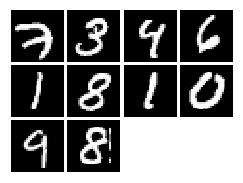

In [9]:
a = plot(X[0:10])

# AE 生成的效果

## Freeze 数字 "1" 分类的encode层，训练decode层

In [ ]:
#====================================== USE FIX ENCODE LAYER of "1" classify

In [11]:
MODELS['1_decode_model'] = tf.keras.models.Sequential([
    tf.keras.layers.Dense(784, activation=None, kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
])

In [12]:
MODELS['1_decode_model'].compile(optimizer='adam',
                    loss=tf.keras.losses.MeanSquaredError())

In [13]:
MODELS['1_decode_model'].fit(encode_input, X, epochs=4)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
55000/55000 [==============================] - 3s 54us/sample - loss: 0.02541s
Epoch 2/4
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0188
Epoch 3/4
55000/55000 [==============================] - 2s 38us/sample - loss: 0.01870s - loss: 0.018 - ETA: 0s - loss
Epoch 4/4
55000/55000 [==============================] - 2s 39us/sample - loss: 0.0187


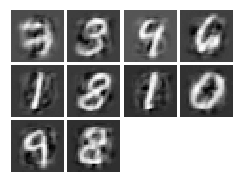

In [16]:
_ = MODELS['1_decode_model'].predict(encode_input[0:10])
a = plot(_)

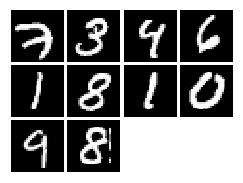

In [17]:
a = plot(X[0:10])

## AE 端到端 : simple case

In [ ]:
#====================================== USE UNFIXED ENCODE LAYER

In [19]:
MODELS['AE_model'] = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337)),
    tf.keras.layers.Dense(784, activation=None, kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
])

In [20]:
MODELS['AE_model'].compile(optimizer='adam',
                   loss=tf.keras.losses.MeanSquaredError())
MODELS['AE_model'].fit(X, X, epochs=2)

Epoch 1/2
55000/55000 [==============================] - 4s 76us/sample - loss: 0.0158
Epoch 2/2
55000/55000 [==============================] - 3s 58us/sample - loss: 0.00840s 


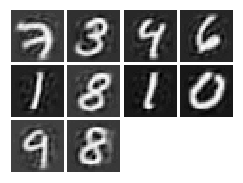

In [21]:
a = plot(MODELS['AE_model'].predict(X[0:10]))

## 【!! ing】启发式encode层

In [ ]:
#====================================== USE STRAIGHT POOLING + DECODE_LAYER

In [ ]:
#====================================== USE STRAIGHT POOLING + STRAIGHT POOLING DECODE

# 分析原始输入各维、中间层各维分布

In [ ]:
#====================================== Middle Layer output Model

## 定义一个便于分析中间层的模型

In [73]:
X_placeholder = tf.keras.layers.Input(shape=(784,),dtype=tf.float32)
gen_placeholder = tf.keras.layers.Input(shape=(128,),dtype=tf.float32)

layer1 = tf.keras.layers.Dense(
    128, activation=None, kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
relu_layer = tf.keras.layers.ReLU()
layer2 = tf.keras.layers.Dense(
    784, activation=None, kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))

middle_outputs = layer1(X_placeholder)
_1 = relu_layer(middle_outputs)
# _1 = middle_outputs
outputs = layer2(_1)
gen_outputs = layer2(gen_placeholder)

MODELS['AE_model_tf'] = tf.keras.Model(X_placeholder, outputs)
MODELS['AE_model_tf_encode_layer'] = tf.keras.Model(inputs=X_placeholder, outputs=middle_outputs)
MODELS['AE_model_tf_decode_layer'] = tf.keras.Model(gen_placeholder, gen_outputs)

MODELS['AE_model_tf'].compile(optimizer='adam',
                   loss=tf.keras.losses.MeanSquaredError())
MODELS['AE_model_tf'].fit(X, X, epochs=2)



Epoch 1/2
55000/55000 [==============================] - 5s 97us/sample - loss: 0.0157
Epoch 2/2
55000/55000 [==============================] - 4s 74us/sample - loss: 0.0082


#### one small trial: no relu, better loss result.
从表达上来说，毕竟也压缩到128维了，应该不完全是学个恒等？

In [71]:
MODELS['AE_model_tf_decode_layer'].summary()
MODELS['AE_model_tf'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               101136    
Total params: 101,136
Trainable params: 101,136
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               100480    
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dens

## 原始输入分析

### 每一维度除去0 / 1的极端值大致处于均匀分布

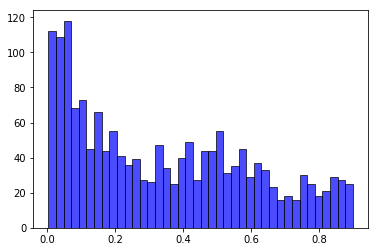

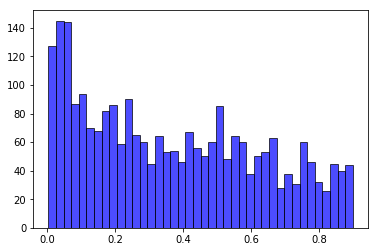

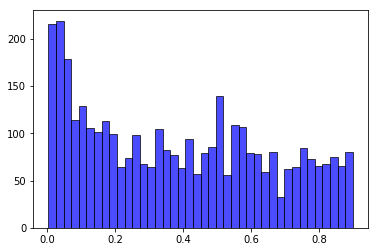

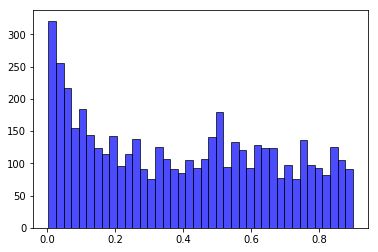

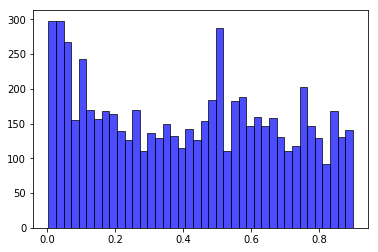

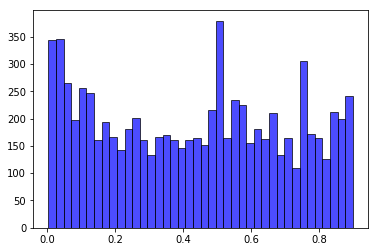

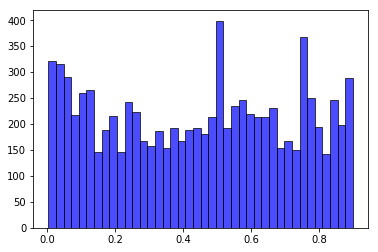

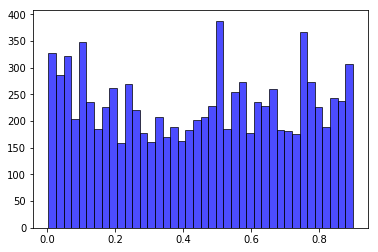

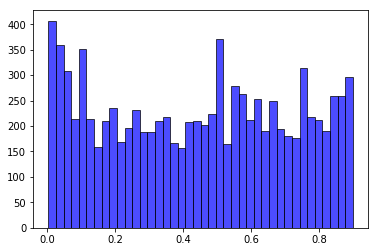

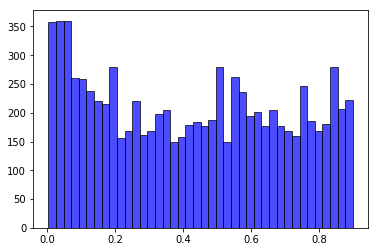

In [49]:
for i in ([120+j for j in range(10)]):
    dim_ = X[:,i]
    if stats.describe(dim_).variance > 0.01:
        dim_ = dim_[(dim_> 0.0) & (dim_ < 0.9)]
        plt.hist(dim_, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
        plt.show()

### 特定维度上有一些相关性

In [44]:
for i in ([120+j for j in range(10)] + [400+j for j in range(10)]):
    print i, ': coef: ', np.corrcoef(X[y_label == 1, 120],X[y_label == 1, i])[0,1]

print '================'
for i in range(784):
    if np.corrcoef(X[y_label == 1, 120],X[y_label == 1, i])[0,1] > 0.5:
        print i, ': coef: ', np.corrcoef(X[y_label == 1, 120],X[y_label == 1, i])[0,1]

120 : coef:  1.0
121 : coef:  0.5694842776797566
122 : coef:  0.18477821642669387
123 : coef:  0.02079021094922234
124 : coef:  0.003934534936129204
125 : coef:  -0.0033816435400494723
126 : coef:  -0.00462650085483818
127 : coef:  -0.002496895948717937
128 : coef:  0.005801214854331849
129 : coef:  0.003648864944564496
400 : coef:  -0.0020980912101178518
401 : coef:  -0.0028060664051388494
402 : coef:  -0.0033113361829081684
403 : coef:  0.02789415282972582
404 : coef:  0.02668095952810403
405 : coef:  0.007442985623928713
406 : coef:  -0.03810346075121097
407 : coef:  -0.015925655241179493
408 : coef:  0.01193505786412778
409 : coef:  0.04523392735806065
120 : coef:  1.0
121 : coef:  0.5694842776797566
148 : coef:  0.7938519605553143
149 : coef:  0.5548987719392267


/Users/bytedance/miniconda3/envs/tf1/lib/python2.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/bytedance/miniconda3/envs/tf1/lib/python2.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## 中间输入分析 

In [74]:
middle_ret = MODELS['AE_model_tf_encode_layer'].predict(X)

In [77]:
relu_middle_ret = np.clip(middle_ret, a_min=0, a_max=np.inf)

### 有一些激活神经元基本没起到作用

不同初始化的时候，s_dim的输出可能不一样

In [78]:
s_dim = []
for i in range(128):
    dim_ = relu_middle_ret[:,i]
    if stats.describe(dim_).variance < 0.01:
        s_dim.append(i)

print s_dim

[1, 6, 8, 9, 16, 20, 21, 23, 28, 31, 32, 36, 39, 41, 44, 45, 47, 52, 56, 57, 59, 61, 63, 64, 72, 74, 75, 77, 83, 89, 92, 93, 94, 96, 98, 100, 101, 105, 107, 111, 113, 115, 117, 123, 127]


### 单个神经元有一定截尾正态性; 神经元之间不能被视为独立的正态变量

In [79]:
corr_dims = []
corr_relu_dims = []

for i in range(128):
    corr_ = np.corrcoef(middle_ret[:,120], middle_ret[:,i])[0,1]
    if corr_ > 0.2:
        corr_dims.append(i)
    if corr_ > 0.5:
        print i, ', corr: ', corr_

print "corr dims: ", corr_dims
        
for i in range(128):
    corr_ = np.corrcoef(relu_middle_ret[:,120], relu_middle_ret[:,i])[0,1]
    if corr_ > 0.2:
        corr_relu_dims.append(i)
    if corr_ > 0.5:
        print i, ', corr: ', corr_

        
print "corr relu dims: ", corr_relu_dims

120 , corr:  0.9999999999999998
corr dims:  [0, 2, 3, 4, 7, 10, 11, 12, 13, 14, 17, 18, 22, 24, 26, 29, 30, 35, 38, 40, 42, 43, 46, 48, 50, 53, 55, 58, 62, 65, 66, 68, 69, 70, 79, 80, 81, 82, 85, 86, 87, 88, 90, 91, 95, 97, 99, 102, 103, 104, 108, 109, 112, 114, 118, 119, 120, 121, 122, 124, 125]
120 , corr:  0.9999999999999998
corr relu dims:  [0, 2, 3, 4, 7, 10, 11, 12, 13, 14, 17, 18, 22, 24, 26, 29, 30, 35, 38, 40, 42, 43, 46, 48, 50, 53, 55, 58, 62, 65, 66, 68, 69, 70, 79, 80, 81, 82, 85, 86, 87, 88, 90, 91, 95, 97, 99, 102, 103, 104, 108, 109, 112, 114, 118, 119, 120, 121, 122, 124, 125]


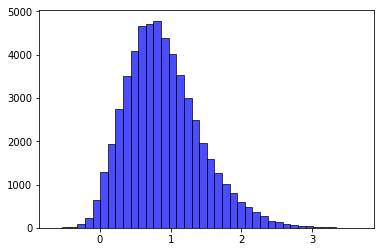

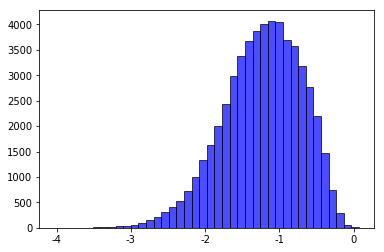

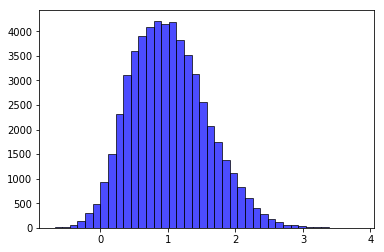

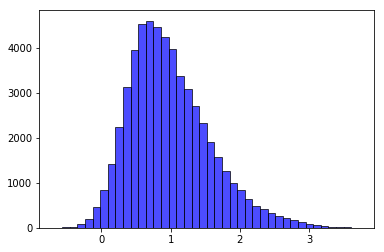

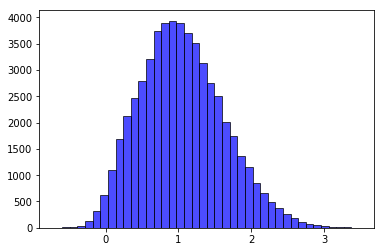

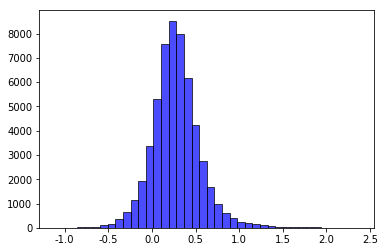

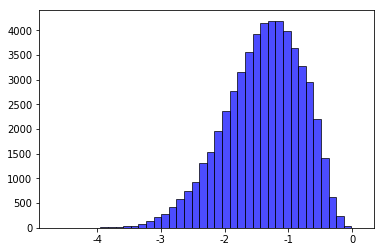

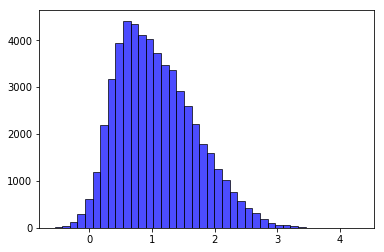

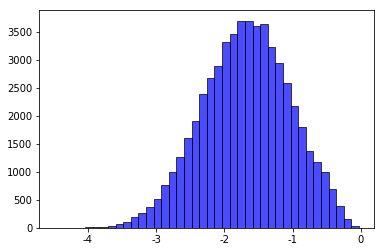

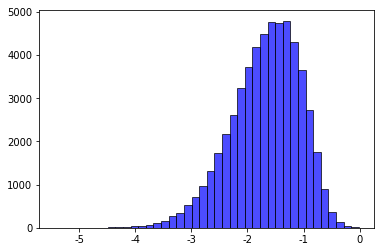

In [80]:
for i in ([j for j in range(10)]):
    dim_ = middle_ret[:,i]
    if stats.describe(dim_).variance > 0.01:
        plt.hist(dim_, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
        plt.show()

### 【？】如果去掉relu，encode层是个正态吗
比较勉强算带偏的正态


## N(0,1)  + decode层的生成效果：看不出任何东西

不行。证明了必须从正确的分布中采样；要保证采出来的东西是能与原始点对应上的

In [ ]:
#------------ 1. N(0,1) + relu 

In [90]:
randn_input = np.reshape(np.random.randn(12800), (100,128))

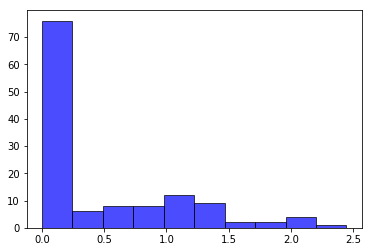

(array([ 1.,  2., 15., 22., 27., 15., 17., 20.,  4.,  5.]),
 array([-2.42204284, -1.93519268, -1.44834253, -0.96149238, -0.47464223,
         0.01220793,  0.49905808,  0.98590823,  1.47275838,  1.95960854,
         2.44645869]),
 <a list of 10 Patch objects>)

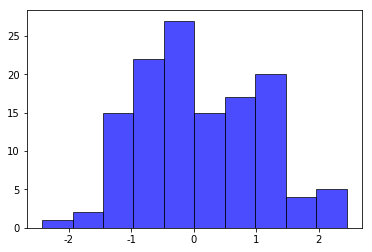

In [91]:
inp = np.clip(randn_input[0], a_min=0, a_max=np.inf)

plt.hist(inp, bins=10, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.show()
plt.hist(randn_input[0], bins=10, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)

==================================

有了框架之后，这样的事就是能轻松而正确地复现，于是没意义了；不过总结一类的 star 不是依然很多吗，但没有被当做基本框架 / api 来用
但这里的基本 api 一定是解决或优化了一个新的共性问题才有希望的，对我来说还太远了

=================== 看看randn生成的效果

理论上由于这个 randn 不知道原先的点是什么，所以decode效果不应该特别行

In [107]:
randn_input = np.reshape(np.random.randn(12800), (100,128))
inp = np.clip(randn_input, a_min=0, a_max=np.inf)
gen_1 = MODELS['AE_model_tf_decode_layer'].predict(inp)

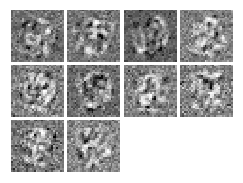

In [108]:
a = plot(gen_1[0:10])

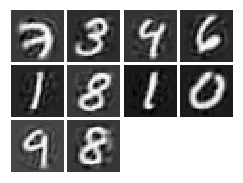

In [97]:
X_input = MODELS['AE_model_tf_encode_layer'].predict(X)
inp = np.clip(X_input, a_min=0, a_max=np.inf)
gen_2 = MODELS['AE_model_tf_decode_layer'].predict(inp)
a = plot(gen_2[0:10])

## N(0,1) + 从 X 中采样的生成效果：极度模糊

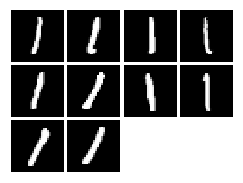

In [102]:
a = plot(X[y_label == 1][0:10])

In [103]:
raw_inp = MODELS['AE_model_tf_encode_layer'].predict(X[y_label == 1][0:10])

In [109]:
randn_input = np.reshape(np.random.randn(1280), (10,128))
inp = raw_inp + randn_input
gen_3 = MODELS['AE_model_tf_decode_layer'].predict(inp)

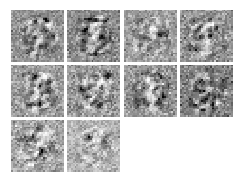

In [110]:
a = plot(gen_3[0:10])

In [111]:
randn_input = np.reshape(np.random.normal(scale=0.1,size=1280), (10,128))
inp = raw_inp + randn_input
gen_3 = MODELS['AE_model_tf_decode_layer'].predict(inp)

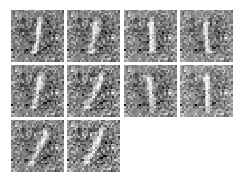

In [112]:
a = plot(gen_3[0:10])

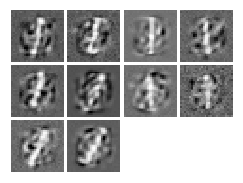

In [120]:
randn_scale = 0.5
randn_input = np.reshape(np.random.normal(scale=randn_scale,size=7840), (10,784))
inp = X[y_label == 1][0:10] + randn_input
gen_4 = MODELS['AE_model_tf'].predict(inp)
a = plot(gen_4[0:10])

## 尝试一下抗噪网络：+N(0,1) 抽样还能还原出来

### 在X上加

In [116]:
randn_input = np.random.randn(55000*784).reshape(55000,784)
X_rand_input = X + randn_input

{'1_decode_model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fe7e8b37410>,
 'AE_model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fe80872ae10>,
 'AE_model_tf': <tensorflow.python.keras.engine.training.Model at 0x7fe83a077f50>,
 'AE_model_tf_decode_layer': <tensorflow.python.keras.engine.training.Model at 0x7fe802385550>,
 'AE_model_tf_encode_layer': <tensorflow.python.keras.engine.training.Model at 0x7fe839f54e90>,
 'init_model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fe801c3dbd0>}

In [122]:
X_placeholder = tf.keras.layers.Input(shape=(784,), dtype=tf.float32)
gen_placeholder = tf.keras.layers.Input(shape=(128,), dtype=tf.float32)
layer1 = tf.keras.layers.Dense(128, activation=None, kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
relu_layer = tf.keras.layers.ReLU()
layer2 = tf.keras.layers.Dense(784, activation=None, kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
middle_outputs = layer1(X_placeholder)
_2 = relu_layer(middle_outputs)
outputs = layer2(_2)
gen_outputs = layer2(gen_placeholder)

MODELS['AE_model_noise'] = tf.keras.Model(X_placeholder, outputs)
MODELS['AE_model_noise_encode_layer'] = tf.keras.Model(X_placeholder, middle_outputs)
MODELS['AE_model_noise_decode_layer'] = tf.keras.Model(gen_placeholder, gen_outputs)

In [125]:
MODELS['AE_model_noise'].compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
MODELS['AE_model_noise'].fit(X_rand_input, X, epochs=5)

Epoch 1/5
55000/55000 [==============================] - 6s 112us/sample - loss: 0.0385
Epoch 2/5
55000/55000 [==============================] - 5s 84us/sample - loss: 0.0369
Epoch 3/5
55000/55000 [==============================] - 4s 75us/sample - loss: 0.0360
Epoch 4/5
55000/55000 [==============================] - 4s 78us/sample - loss: 0.0357
Epoch 5/5
55000/55000 [==============================] - 4s 78us/sample - loss: 0.0355


#### 在原始数据上加上 N(0,1) 来生成一些新数据，可以做到了

In [132]:
randn_inp = np.random.randn(7840).reshape(10, 784)
inp = X[0:10] + randn_inp
ret = MODELS['AE_model_noise'].predict(inp)

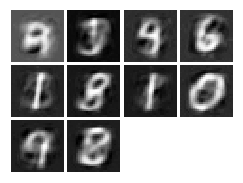

In [133]:
a = plot(ret[0:10])

#### 完全随机，输入抗噪网络，效果也还是不行的

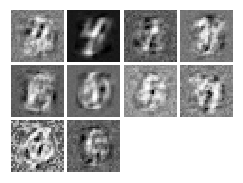

In [130]:
randn_inp = np.random.randn(7840).reshape(10, 784)
ret = MODELS['AE_model_noise'].predict(randn_inp)
a = plot(ret[0:10])

### 【？】在中间层上加

中间层上加，或者模型里就生成 randn，作为噪声的一部分加上去；dropout也是相应的方法

## 尝试一下采样方法：

本质是让原始数据拟合到 N(0,1) 上，使得 N(0,1) 能反向还原到原始数据
把原始数据的相关信息保存在网络中
然后在单点估计的时候，其实我希望取的还是0 那个点，即概率密度最高的那个点？

### 中间encode层拟合N(0,1)分布

https://mp.weixin.qq.com/s/5z3Sx5lw5a3C5DrJbH2mqQ
U sigma混合生成，em算法？先假设生成概率

高斯混合，协方差矩阵的约束：有这一点，就可以学出来了。最好是从诸多1中每个数据点有一个 u sigma，还是所有数据点有整体的高斯混合生成

还原回高斯的一个点：是1是0，难负例继续判断。不需要kl loss，用判别器替代了，直到准确率也不再提升

侧重哪个？

线性模型

拟合混合高斯生成其他办法

维度之间关联性

Em和梯度回传构成了整体计算图流向

MAML

### 拟合 u, sigma

### MCMC 从原始数据中采样

# For test

In [ ]:
upsampling2D
X
encode_model, 128.

In [ ]:
#======================== for test


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_60 (Dense)             (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [214]:
len(s_dim)

239

In [12]:
s_dim = []
for i in range(784):
    dim_ = X[:,i]
    variance = stats.describe(dim_).variance
    if variance < 0.001:
        s_dim.append(i)
print s_dim

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 108, 109, 110, 111, 112, 113, 114, 115, 116, 137, 138, 139, 140, 141, 142, 143, 144, 166, 167, 168, 169, 170, 171, 194, 195, 196, 197, 198, 223, 224, 225, 226, 251, 252, 253, 278, 279, 280, 281, 306, 307, 308, 309, 334, 335, 336, 337, 338, 362, 363, 364, 365, 366, 390, 391, 392, 393, 394, 418, 419, 420, 421, 422, 446, 447, 448, 449, 450, 474, 475, 476, 477, 478, 502, 503, 504, 505, 506, 530, 531, 532, 533, 534, 558, 559, 560, 561, 562, 586, 587, 588, 589, 590, 614, 615, 616, 617, 618, 641, 642, 643, 644, 645, 646, 668, 669, 670, 671, 672, 673, 674, 675, 696, 697, 698, 699, 700, 701, 702, 703, 704, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 749, 750, 751, 752, 753, 754, 75

In [139]:
encode_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
])
encode_model.layers[0].set_weights(whole_model.layers[0].get_weights())

ValueError: You called `set_weights(weights)` on layer "dense_52" with a  weight list of length 2, but the layer was expecting 0 weights. Provided weights: [array([[ 0.0522367 , -0.08698255, -0.03261442, .....

In [143]:
layer1 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
outputs = layer1(X)

AttributeError: 'tuple' object has no attribute 'ndims'

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

/Users/bytedance/miniconda3/envs/tf1/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


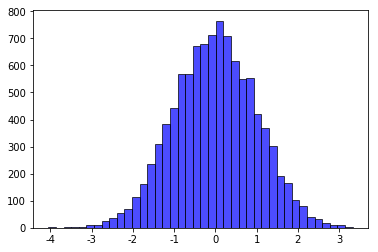

In [130]:
data = np.random.randn(10000)
plt.hist(data, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.show()

In [106]:
with tf.Session() as sess:
    batch_size = 32
    epoch = 1
    sample_total_num = X.shape[0]
    
    inputs = tf.keras.Input(shape=(128,), dtype="float32")
    labels = tf.keras.Input(shape=(784,), dtype="float32")
    decode_layer = tf.keras.layers.Dense(784, activation=None, kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
    outputs = decode_layer(inputs)
    loss = tf.losses.mean_squared_error(labels, outputs)
    
    train_optim = tf.train.AdamOptimizer().minimize(loss)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print sess.run(loss, feed_dict={inputs: encode_input, labels: X})
    print sess.run(outputs, feed_dict={inputs: encode_input[0:10]})
    
    for _ in range(epoch):
        start_idx = 0
        end_idx = start_idx + batch_size
        
        while end_idx < sample_total_num:
            x_batch = encode_input[start_idx: end_idx]
            y_batch = X[start_idx: end_idx]
            sess.run(train_optim, feed_dict={inputs: x_batch, labels: y_batch})
            
            start_idx = end_idx
            end_idx = start_idx + batch_size
    
    print 'loss', sess.run(loss, feed_dict={inputs: encode_input, labels: X})
    print 'logits', sess.run(outputs, feed_dict={inputs: encode_input[0:10]})
    

0.1420239
[[-0.04594732  0.33756417  0.1566546  ...  0.24597922 -0.17298439
   0.3344317 ]
 [-0.07378011  0.05996239 -0.12274773 ... -0.06251512 -0.2631857
   0.05318589]
 [-0.10832264 -0.0557168  -0.1855376  ...  0.11941113 -0.25670412
   0.07930714]
 ...
 [-0.21102242  0.1211073   0.08913418 ...  0.04049285 -0.4931556
   0.30459324]
 [-0.05147105 -0.0260731  -0.0332742  ...  0.1318626  -0.35736552
  -0.01866552]
 [-0.1591911   0.01580061 -0.15785278 ... -0.10034064 -0.1855712
   0.08295621]]
loss 0.019268878
logits [[ 5.02898656e-05 -6.96065545e-05  1.79591880e-05 ... -4.69383085e-05
   2.32808129e-03  2.22109840e-04]
 [ 9.72702401e-06  1.92960375e-04  1.02820341e-05 ... -1.65716570e-04
   1.67551870e-03  1.59208430e-04]
 [ 5.67363240e-05  1.16302865e-04  1.76175527e-05 ... -8.47055926e-05
  -6.73140166e-04  2.28695688e-04]
 ...
 [-6.25893736e-05  1.29115419e-04  3.38650570e-05 ... -3.53581854e-05
   1.16595533e-04  3.09395487e-04]
 [ 7.97955436e-05  1.93757587e-05  2.02916854e-05 ..

In [ ]:
stats.describe(dim_)

In [32]:
print "print 4"

print 4


In [ ]:
# #-------------- if regenerate layer1
# layer1 = tf.keras.layers.Dense(
#     128, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(seed=1337))
# layer1.get_weights()